### RoFormer

Repasemos el mecanismo de atención.

Sean:

- $Q\in\mathbb{R}^{l\times d_k}$, la secuencia de consultas.
- $K\in\mathbb{R}^{l\times d_k}$, la secuencia de claves.
- $V\in\mathbb{R}^{l\times d_v}$, la matriz de valores.

Se define el mecanismo de atención como:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Veamos el producto $QK^T$. Pensemos en la transpuesta $K^T$, no solo como la matriz $K$ con sus elementos cambiados de orden, sino como la matriz adjunta de $K$. Es decir, si $Q$ es un vector columna que contiene vectores fila como elementos, entonces $K^T$ es un vector fila que contiene vectores columna como elementos. Por lo tanto, el producto $QK^T$ es una matriz que contiene los productos internos de los vectores de $\vec{q}^m$ y $\vec{k}_n$ de $Q$ y $K^T$.

$$ QK^T = \begin{bmatrix} \vec{q}^1 \\ \vec{q}^2 \\ \vdots \\ \vec{q}^l \end{bmatrix} \begin{bmatrix} \vec{k}_1 & \vec{k}_2 & \cdots & \vec{k}_l \end{bmatrix} = \begin{bmatrix} \vec{q}^1\vec{k}_1 & \vec{q}^1\vec{k}_2 & \cdots & \vec{q}^1\vec{k}_l \\ \vec{q}^2\vec{k}_1 & \vec{q}^2\vec{k}_2 & \cdots & \vec{q}^2\vec{k}_l \\ \vdots & \vdots & \ddots & \vdots \\ \vec{q}^l\vec{k}_1 & \vec{q}^l\vec{k}_2 & \cdots & \vec{q}^l\vec{k}_l \end{bmatrix} $$

En donde, un subíndice indica que hablamos de un vector contravariante, y un superíndice indica que hablamos de un vector covariante. Por lo tanto, el producto interno de $\vec{q}^m$ y $\vec{k}_n$ es un escalar, usando por comodidad la notación bra-ket podemos escribir los productos como:

$$ \vec{q}^m \vec{k}_n = \langle q_m | k_n \rangle$$

Como sabemos, el mecanismo de atención propia no captura la información de la posición de las palabras. Se supone entonces, que esta información se encuentra embebida en los vectores $\ket{q_m}$ y $\ket{k_n}$, veamos esto en detalle. Sea $X\in\mathbb{R}^{l\times d}$ una secuencia de entrada, tales que las matrices $Q$ y $K$ son transformaciónes de $X$, es decir, para cada vector de $Q$ y $K$, podemos escribir:

$$ \ket{q_m} = \ket{f_Q(\vec{x}^m, m)} \quad \text{y} \quad \ket{k_n} = \ket{f_K(\vec{x}^n, n)}$$

En donde los terminos $m$ y $n$ son las posiciones de las palabras en la secuencia, las cuales proveen información de la posición absoluta de las palabras. En el paper original "Attention is All You Need", se propone que la información de la posición de las palabras se puede capturar mediante la suma de funciones sinusoidales de diferentes frecuencias a las señales de entrada, y proyectando estas señales a los espacios de consulta y clave. Es decir, se propone que las funciones $f_Q$ y $f_K$ sean de la forma:

$$\ket{f_Q(\vec{x}^m, m)} =  W^Q (\vec{x}^m + \vec{p}^m)^T\quad \text{y} \quad \ket{f_K(\vec{x}^n, n)} = W^K (\vec{x}^n + \vec{p}^n)^T$$

Sin embargo, este metodo falla en capturar la información de la posición relativa de las palabras en el producto $\langle q_m | k_n \rangle$. Varios metodos fueron propuestos para capturar esta información en la codificación posiciónal por suma, por ejemplo usando parametros entrenables, sin embargo, el metodo propuesto por el paper "RoFormer: Enhanced Transformer with Rotary Position Embedding" propone una forma diferente, deduciendola a partir del mismo producto. Veamos esto en detalle. Sea $g$ una función tal que:

$$ \langle q_m | k_n \rangle = \langle f_Q(\vec{x}^m, m) | f_K(\vec{x}^n, n) \rangle = g(\vec{x}^m, \vec{x}^n, m-n)$$

Entonces, el valor de $g$ depende directamente de la diferencia de las posiciones de las palabras en la secuencia. Proponemos entonces, transformaciones $f_Q$ y $f_K$ de la forma:

$$\ket{f_Q(\vec{x}^m, m)} =  W^Q (\vec{x}^m)^T e^{-im\theta} \quad \text{y} \quad \ket{f_K(\vec{x}^n, n)} = W^K (\vec{x}^n)^T e^{-in\theta}$$

Luego, los terminos de interacción seran:

$$ \langle q_m | k_n \rangle = \langle f_Q(\vec{x}^m, m) | f_K(\vec{x}^n, n) \rangle = (\vec{x}^m (W^Q)^T W^K (\vec{x}^n)^T) e^{i(m-n)\theta}$$

### RMS Norm

Sean:

- $X\in\mathbb{R}^{l\times d}$, una secuencia de entrada.

In [9]:
from torch import Tensor, ones, rsqrt
from torch.nn import Module
from torch.nn import Parameter

class RMSNorm(Module):
    def __init__(self, model_dimension: int, epsilon: float = 1e-6):
        super().__init__()
        self.epsilon = epsilon
        self.weight = Parameter(ones(model_dimension))

    def norm(self, input: Tensor) -> Tensor:
        return input * rsqrt(input.pow(2).mean(-1, keepdim=True) + self.epsilon)

    def forward(self, input: Tensor) -> Tensor:
        output = self.norm(input.float()).type_as(input)
        return output * self.weight

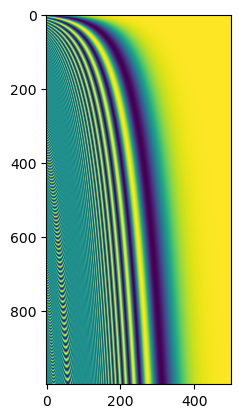

In [10]:
import torch

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis

from matplotlib.pyplot import imshow

t = precompute_freqs_cis(1000, 1000)
imshow(t.real.cpu().numpy())

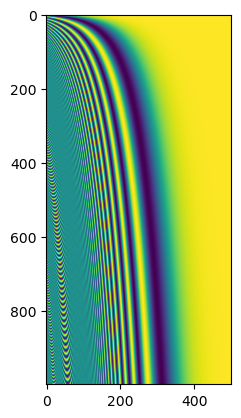

In [11]:
import math
from torch import Tensor
from torch import exp
from torch import polar, ones_like

def precompute_complex_positional_embeddings(model_dimension: int, sequence_lenght_limit: int, scaling_factor: float = 10000.0) -> Tensor:
    frequencies = Tensor(sequence_lenght_limit, model_dimension // 2)
    for dimension in range(model_dimension // 2):
        frequencies[:, dimension] = - 2 * dimension / model_dimension * math.log(scaling_factor)
        frequencies[:, dimension] = exp(frequencies[:, dimension])
        for sequence in range(sequence_lenght_limit):
            frequencies[sequence, dimension] = sequence * frequencies[sequence, dimension]
    return polar(ones_like(frequencies), frequencies)

from matplotlib.pyplot import imshow

t = precompute_complex_positional_embeddings(1000, 1000)
imshow(t.real.cpu().numpy())

In [12]:
from torch import view_as_real, view_as_complex
import torch
from typing import Tuple

def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1])
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)

def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)


cis = precompute_freqs_cis(4, 4)
input = ones(4, 4, 4, 4)



def apply_rotatory_embeddings(sequence: Tensor, rotatory_embeddings: Tensor) -> Tensor:
    batch_size, sequence_lenght, number_of_heads, heads_dimension = sequence.shape
    sequence = sequence.view(batch_size, sequence_lenght, number_of_heads, heads_dimension // 2, 2)
    sequence = view_as_complex(sequence)
    rotatory_embeddings = rotatory_embeddings.unsqueeze(0).unsqueeze(2)
    sequence = sequence * rotatory_embeddings
    sequence = view_as_real(sequence)
    return sequence.view(batch_size, sequence_lenght, number_of_heads, heads_dimension)


output1, output2 = apply_rotary_emb(input, input, cis)
output3 = apply_rotatory_embeddings(input, cis)

assert torch.allclose(output1, output3)

In [7]:
import torch


def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    """torch.repeat_interleave(x, dim=2, repeats=n_rep)"""
    bs, slen, n_kv_heads, head_dim = x.shape
    if n_rep == 1:
        return x
    return (
        x[:, :, :, None, :]
        .expand(bs, slen, n_kv_heads, n_rep, head_dim)
        .reshape(bs, slen, n_kv_heads * n_rep, head_dim)
    )

from torch import repeat_interleave
tensor = torch.randn(4,4,4,4)
assert torch.allclose(repeat_kv(tensor,4), repeat_interleave(tensor, 4, 2))

print(repeat_kv(tensor,4).shape, repeat_interleave(tensor, 4, 2).shape)

torch.Size([4, 4, 16, 4]) torch.Size([4, 4, 16, 4])


In [14]:
from typing import Optional
from torch import zeros, repeat_interleave
from torch.nn import Module
from torch.nn import Parameter
from torch.nn import Linear
from torch.nn.functional import scaled_dot_product_attention

def split(sequence: Tensor, number_of_heads: int) -> Tensor:
    batch_size, sequence_length, model_dimension = sequence.shape
    sequence = sequence.view(batch_size, sequence_length, number_of_heads, model_dimension // number_of_heads)
    sequence = sequence.transpose(1, 2)
    return sequence

def concat(sequence: Tensor) -> Tensor:
    batch_size, number_of_heads, sequence_lenght, heads_dimension = sequence.shape
    sequence = sequence.transpose(1, 2)
    sequence = sequence.reshape(batch_size, sequence_lenght, heads_dimension* number_of_heads)
    return sequence

def apply_rotatory_embeddings(sequence: Tensor, rotatory_embeddings: Tensor) -> Tensor:
    batch_size, number_of_heads, sequence_lenght, heads_dimension = sequence.shape
    sequence = sequence.view(batch_size, number_of_heads, sequence_lenght, heads_dimension // 2, 2)
    sequence = view_as_complex(sequence)
    sequence = sequence * rotatory_embeddings
    sequence = view_as_real(sequence)
    return sequence.view(batch_size, number_of_heads, sequence_lenght, heads_dimension)

class Cache(Module):
    def __init__(self, batch_size_limit: int, sequence_lenght_limit: int, number_of_heads: int, heads_dimension: int):
        super().__init__()
        self.sequence_cache = Parameter(data=zeros(batch_size_limit, sequence_lenght_limit, number_of_heads, heads_dimension), requires_grad=False)
        self.sequence_cache = self.sequence_cache.transpose(1, 2)

    def forward(self, sequence: Tensor, start_position: int) -> Tensor:
        batch_size, sequence_lenght = sequence.size(0), sequence.size(2)
        self.sequence_cache[:batch_size, :, start_position: start_position+sequence_lenght]
        return self.sequence_cache[:batch_size, :, :start_position+sequence_lenght]

class Attention(Module):
    def __init__(
        self, 
        model_dimension: int, 
        number_of_heads: int, 
        number_of_kv_heads: int,
        batch_size_limit: int, 
        sequence_lenght_limit: int
    ):
        super().__init__()
        self.model_dimension = model_dimension
        self.heads_dimension = model_dimension // number_of_heads
        self.number_of_heads = number_of_heads
        self.number_of_kv_heads = number_of_kv_heads
        self.repeats = self.number_of_heads // self.number_of_kv_heads

        self.q_projector = Linear(model_dimension, self.heads_dimension * self.number_of_heads, bias=False)
        self.k_projector = Linear(model_dimension, self.heads_dimension * self.number_of_kv_heads, bias=False)
        self.v_projector = Linear(model_dimension, self.heads_dimension * self.number_of_kv_heads, bias=False)
        self.output_projector = Linear(self.number_of_heads * self.heads_dimension, model_dimension, bias=False)

        self.k_cache = Cache(batch_size_limit, sequence_lenght_limit, self.number_of_kv_heads, self.heads_dimension)
        self.v_cache = Cache(batch_size_limit, sequence_lenght_limit, self.number_of_kv_heads, self.heads_dimension)
        
    def forward(self, sequence: Tensor, rotatory_embeddings: Tensor, start_position: int, mask: Optional[Tensor] = None) -> Tensor:
        query, key, value = self.q_projector(sequence), self.k_projector(sequence), self.v_projector(sequence)        
        query, key, value = split(query, self.number_of_heads), split(key, self.number_of_kv_heads), split(value, self.number_of_kv_heads)
        query, key = apply_rotatory_embeddings(query, rotatory_embeddings), apply_rotatory_embeddings(query, rotatory_embeddings)
        key, value = self.k_cache(key, start_position), self.v_cache(value, start_position)
        key, value = repeat_interleave(key, self.repeats, 1), repeat_interleave(value, self.repeats, 1)
        attention = scaled_dot_product_attention(query, key, value, mask)
        attention = concat(attention)
        return self.output_projector(attention)